# Estimación de precios de los alojamientos en la plataforma Airbnb
-----------------------------------------------------------------------------------------------
#### Joan Muntaner Ferrer


## Introducción

La plataforma Airbnb es una plataforma digital que permite al usuario presentar y reservar alojamientos en alquiler. Es una plataforma presente en más de 192 países. En Mallorca dispone de más de 14000 alojaminetos. Sin embargo, si un nuevo usuario tiene intención de incluir su alojamiento para el alquiler siempre tiene el problema de estipular el precio del alquiler. 

En este documento se presentará un modelo, siguiendo el aprendizaje profundo, que ayude al usuario a estipular dicho precio del alquiler. En otras palabras, se pretende que el modelo que se presentará en este documento sea capaz de epredecir los valores para un alojamiento concreto, teniendo en cuenta distintos parámetros como, por ejemplo, la ubicación, el número de habitaciones, baños e incluso si el alojamiento cuenta con wifi o no. 

Para el entrenamiento del modelo se dispone de una base de datos reales sobre la isla de Mallorca. A partir de ella se pretende entrenar el modelo para que sea capaz de predecir el precio adecuado al alojamiento. No obstante, la base de datos que disponemos presenta varias columnas con valores problematicos, es decir, hay varias columnas con valores NAN en ellas, valores atípicos (outliers), colummnas con valores encadenados, etc. Por este motivo, este documento se dividirá en dos grandes partes:

* Limpieza y preparación de la base de datos
* Implementación del modelo

A continuación se mostrarán distintos apartados explicando el coódigo que se ha implementado.

## Librerías usadas

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from statsmodels.graphics.gofplots import qqplot
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import  KNeighborsRegressor
from sklearn.metrics import  mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

## Funciones

Se han implementado varias funciones con el objetivo de implementar un código más limpio y menos redundante. 

### Funciones para plotear


In [2]:
#Función implementada para visualiar los datos a través de la variable 'price'
def plot_col(df, tittle, col, ylabel):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter( df['id'],col)
    ax.set_title(tittle)
    ax.set_ylabel(ylabel)
    plt.show()

#Función implementada para visualiar la relación de los cuantiles
def qq_plot(df, tittle):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    qqplot(df, line='s',ax =ax)
    ax.set_title(tittle)
    plt.show()

## Carga y visualización de la base de datos

In [3]:
data_frame_airbnb=pd.read_csv('C:/Users/munta/OneDrive/Escritorio/Aprenentatge automatic/Practica Airbnb/airbnb.csv')
data_frame_airbnb.head() 

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,11547,https://www.airbnb.com/rooms/11547,20200919153121,2020-09-21,My home at the beach,"Sun, joy, relax, quality, beach & peace.<br />...",NaN,https://a0.muscache.com/pictures/494126/8c151b...,42942,https://www.airbnb.com/users/show/42942,...,10.0,10.0,10.0,NaN,f,1,1,0,0,0.93
1,100831,https://www.airbnb.com/rooms/100831,20200919153121,2020-09-21,HOUSE IN MALLORCA - WiFi(ET-3045),<b>The space</b><br />House situated in a quie...,NaN,https://a0.muscache.com/pictures/675527/72b329...,529151,https://www.airbnb.com/users/show/529151,...,10.0,10.0,10.0,ETV-3045,t,1,1,0,0,1.47
2,105891,https://www.airbnb.com/rooms/105891,20200919153121,2020-09-20,VILLAGE HOUSE WITH POOL: IDEAL FOR FAMILIES,The house is a street on the outskirts of the ...,The village's population does not reach two th...,https://a0.muscache.com/pictures/1036816/f36ce...,549192,https://www.airbnb.com/users/show/549192,...,10.0,9.0,10.0,ETV/6127,t,2,2,0,0,0.14
3,106833,https://www.airbnb.com/rooms/106833,20200919153121,2020-09-20,Villa with a big pool in Mallorca,<b>The space</b><br />This is a restored old b...,NaN,https://a0.muscache.com/pictures/710218/98134c...,551974,https://www.airbnb.com/users/show/551974,...,10.0,9.0,9.0,ET/1961,f,1,1,0,0,0.09
4,130669,https://www.airbnb.com/rooms/130669,20200919153121,2020-09-20,Room great apartment,Located in a residential neighbourhood and 10m...,"Located in the center of the city, within minu...",https://a0.muscache.com/pictures/866653/58dc48...,643065,https://www.airbnb.com/users/show/643065,...,NaN,NaN,NaN,NaN,t,2,0,2,0,NaN


Visualizamos los 5 primeros datos de nuestra  base de datos. Observamos que esta formada por 74 columnas, todas las columnas forman parte de aspectos a tener en cuenta para el estudio. Sin embargo, de dichas columnas habrá algunas que podamos eliminar (decidiendo que no tienen tanta importancia o peso).


In [4]:
#Creamos una nueva base de datos para trabajar sobre ella y no modificar así la base de datos original
df_airbnb =data_frame_airbnb.copy()

print("Dimensión: ",df_airbnb.shape)
df_airbnb.info()

Dimensión:  (17608, 74)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17608 entries, 0 to 17607
Data columns (total 74 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            17608 non-null  int64  
 1   listing_url                                   17608 non-null  object 
 2   scrape_id                                     17608 non-null  int64  
 3   last_scraped                                  17608 non-null  object 
 4   name                                          17607 non-null  object 
 5   description                                   17393 non-null  object 
 6   neighborhood_overview                         8213 non-null   object 
 7   picture_url                                   17608 non-null  object 
 8   host_id                                       17608 non-null  int64  
 9   host_url                             

Con esta impresión observamos que la base de datos esta formado por 19 varaibles tipo float, 21 variables de tipo entero y 34 objetos. Además, podemos visualizar practicamente todas las columnas presentan algún valor nulo, y en especial en aquellas columnas que son de tipo float y tienes todos sus compenentes nulos, como por ejemplo la columna 'bathrooms'. De esta manera, ya podemos suponer que habrá que trabajar eliminar o transformar dichos valores nulos (NAN).


## 1. Limpieza y preparación de la base de datos

### 1.1 Columna 'price'

Al hacer un modelo sobre la estimación de los precios de alojamiento es inevitable fijarse en la columna 'price'. Podemos observar que dicha columna es de tipo objeto. 

In [5]:
df_airbnb['price'].head(5)

0     $89.00
1    $175.00
2    $140.00
3    $200.00
4    $110.00
Name: price, dtype: object

Esto se debe que esta columna es una cadena de valores, esta formada por el valor númerico del precio como tal y por el símbolo '$'. Esta configuración puede dar problemas al modelo a la hora de su aprendizaje, por ello,  vamos a transformar esta columna en tipo float para el estudio, eliminando el símbolo.


In [6]:
df_airbnb['price'] = df_airbnb['price'].str.replace("$","").str.replace(",","").astype(float)
df_airbnb['price'].dtype

dtype('float64')

Realizamos una descripción de la columna 'price' para observar mejor su composición.

In [7]:
df_airbnb.price.describe() 

count    17608.000000
mean       244.383561
std        409.958169
min          0.000000
25%        110.000000
50%        179.000000
75%        275.000000
max      20736.000000
Name: price, dtype: float64

Gracias a la función describe() podemos observar los percentiles de la variable 'price' y suponer que los valores se encuentran entre 100 y 300 dólares aproximadamente. Sin embargo, el valor máximo es de 20736 dólares. Podemos concluir que la variable 'price' presenta varios outliers. 

Para una mejor comprensión, decidimos plotear los datos de la columna 'price'.


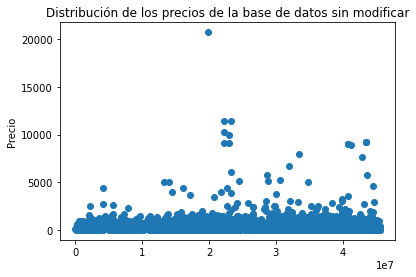

In [8]:
#Función para plotear
plot_col(df_airbnb, 'Distribución de los precios de la base de datos sin modificar', df_airbnb.price, 'Precio') 

En la gráfica obtenida observamos como las suposiciones anteriores están muy alejadas, casi todos los datos se sitúan entorno a los 1000 dólares y por encima de los 3500 dólares aproximadamente encontramos varios outliers. Como se ha mencionado anteriormente, estos outliers pueden ser peligrosos para el aprendizaje del modelo, hay  que filtrarlos.


#### Filtrado de precios

Es momento de filtrar los precios del alojamiento con el objetivo de evitar que los outliers afecten al comportamiento del modelo. Para ello se decide tenner en cuenta los alojamientos con un precio menor de 2000 dólares. 


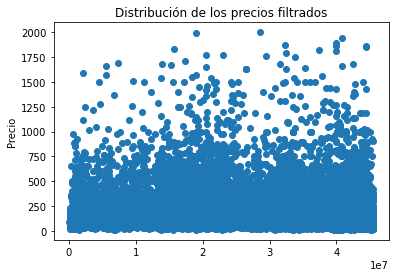

In [9]:
df_airbnb_fil = df_airbnb.loc[(df_airbnb.price <=2000) & (df_airbnb.price>0)]
df_airbnb_fil.price.describe()
plot_col(df_airbnb_fil, 'Distribución de los precios filtrados', df_airbnb_fil.price, 'Precio')

Gracias al nuevo plot obtenido podemos observar que la mayoría de los datos se centran por debajo de los 1500 dólares. Sin embargo, se siguen visualizando varios outliers. Es necesario filtrar aún más lo precio. No obstante, se decide recurrir a la representación de la distribución de los cuantiles para decidir que límite de filtrado realizamos.


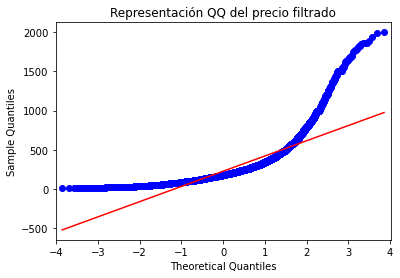

In [10]:
# Función para la representación del Q-Q plot
qq_plot(df_airbnb_fil.price, 'Representación QQ del precio filtrado')

El qqplot nos sirve para visualizar la distribución de los precios en función de sus cuantiles, es decir, podemos observar que tan cerca están los precios respecto a sus cuantiles. Como podemos ver, sigue habiendo bastantes datos alejados. Es necesario filtrar aún más los datos de la variable 'price'. Se ha decidido limitar los datos hasta el quartil 3, es decir, al cuantil 0.875.


In [11]:
q3 = df_airbnb_fil.price.quantile([0.875])
print('En cuantil 3 representado en la gráfica corresponde al valor del precio: ', q3)

En cuantil 3 representado en la gráfica corresponde al valor del precio:  0.875    381.0
Name: price, dtype: float64


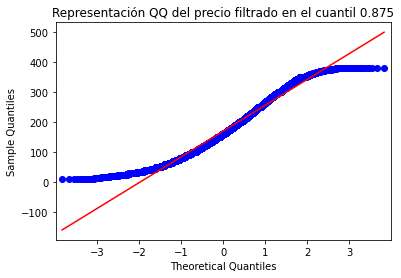

In [12]:
df_airbnb_q = df_airbnb_fil.loc[(df_airbnb_fil.price <=381) & (df_airbnb_fil.price>0)]
qq_plot(df_airbnb_q.price, 'Representación QQ del precio filtrado en el cuantil 0.875')

Esta representación de la distribución de los datos es más aceptable. A partir de este momento, trabajaremos con esta cantidad de datos. 

### 1.2 Valores booleanos

Visualizando los datos, observamos como hay varias columnas de la base de datos que presentan valores representados con 't' o f', estos valores representan variables booleanas. Por ende, es necesario modificar dichas variables para su futuro uso en el modelo.

En primer lugar, crearemos una lista para almacenar todas las columnas que presentan dichas variables con el formato descrito. Posteriormente, recorremos dicha lista y reemplazamos los valores 'f' y 't' por 0 y 1 respectivamente. 


In [13]:
columnas_bool = [] #Realizamos una lista para todas las columnas con 'f' o 't'

# Recorremos la base de datos de izquierda a derecha y vamos comprobando la primera posición de cada columna
for n_col in df_airbnb_q.columns:
    if ((df_airbnb_q.loc[0, n_col] == 't') | (df_airbnb_q.loc[0, n_col] == 'f')): 
        columnas_bool.append(n_col)

#Recorremos la lista obtenido y reemplazamos los valores de 'f' y 't'
for i in columnas_bool: 
    df_airbnb_q[i] = df_airbnb_q[i].replace('f',0)
    df_airbnb_q[i] = df_airbnb_q[i].replace('t',1)
   

C:\Users\munta\anaconda3\envs\base1\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\munta\anaconda3\envs\base1\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


De esta manera, hemos obtenido una configuración binaria de las diferentes columnas que representaban booleanos.  

### 1.3 Columna 'amenities'

Cuando se decide estipular el precio de un alojamiento se tienen en cuenta muchos aspectos como las dimensiones del alojamiento, número de habitaciones y baños, su ubicación, electrodomésticos con los que cuenta, etc.  
En este apartado nos centraremos en la columna 'amenities' que nos indica el equipamiento de cada alojamiento como electrodomésticos, si hay piscina, si cuenta con wifi, etc.


In [14]:
df_airbnb_q.amenities.head()

0    ["Oven", "Wifi", "Coffee maker", "Dishes and s...
1    ["First aid kit", "Hair dryer", "Iron", "Washe...
2    ["Smoke alarm", "Oven", "Wifi", "Garden or bac...
3    ["Pool", "Free parking on premises", "Air cond...
4    ["Pool", "Washer", "Air conditioning", "Kitche...
Name: amenities, dtype: object

La columna 'amenities' al estar formada por objetos, se decide vectorizar los valores para poder tratar con ellos y limpiarlos, es decir, se van a contemplar estos objetos como columnas nuevas y cada una de ellas se rellenará con un '1' o '0' simulando si el alojamineto tiene o no dicho equipamiento.

In [15]:
count = CountVectorizer(tokenizer=lambda x: x.split(','))
amenities = count.fit_transform(df_airbnb_q.amenities)

Un vez vectorizados los valores de la columna 'amenities', es momento de agregarle nombre a estas nuevas columnas.

In [16]:
columns = count.get_feature_names()
for i, item in enumerate(columns):
    forma = item.replace('"','').replace('[','').replace(']','').strip()
    columns[i] = forma
    
#Creamos una nueva base de datos con sólo los objetovs de la columna 'amenities' de la base de datos con la que trabajamos.
df_amenities = pd.DataFrame(amenities.toarray(),columns=columns) 
df_amenities.drop('',axis=1,inplace = True)
#Eliminamos la columna 'amenities'
df_airbnb_q = df_airbnb_q.drop(['amenities'], axis = 1)

df_amenities.head()

,air conditioning,air conditioning,baby bath,baby bath,baby monitor,babysitter recommendations,babysitter recommendations,baking sheet,barbecue utensils,bathtub,...,private living room,record player,room-darkening shades,shampoo,smoke alarm,table corner guards,tv,tv,washer,wifi
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Una vez creada esta nueva base de datos, podemos observar que hay columnas que se han repetido rellenandose con ceros. Las columnas no se han repetido sólo una vez, en algunos casos han sido más. Por este motivo, se crea una base de datos nueva donde se irá introduciendo cada columna repetida mientras se elimina de la base de datos 'df_amenities' con el fin de tratar tambíen esas columnas repetidas más de una vez. 

In [17]:
df_dupli = pd.DataFrame()

for col in df_amenities.columns:
    if col not in df_dupli.columns:
         if len(df_amenities.filter(like=col).columns) > 1: #Se filtran aquellas columnas con más de 1 aparición
            df_dupli[col] = df_amenities[col].any(1)
            df_dupli = df_dupli.applymap(lambda x: 1 if x else 0)        
            df_amenities.drop(col,axis=1,inplace=True)
            
df_amenities = pd.concat([df_amenities,df_dupli],axis=1,join='inner')
df_amenities.columns = df_amenities.columns.str.replace(' ', '_')
df_amenities.head()

,baking_sheet,barbecue_utensils,bed_linens,ceiling_fan,cleaning_before_checkout,conditioner,dishwasher,freezer,high_chair,indoor_fireplace,...,ski-in/ski-out,smart_lock,smoke_alarm,stove,table_corner_guards,tv,washer,waterfront,wifi,window_guards
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,1,0,1,0
1,0,0,0,0,0,0,0,0,0,1,...,0,0,1,0,0,1,1,0,1,0
2,0,0,0,0,0,0,1,0,1,0,...,0,0,1,1,0,1,1,0,1,0
3,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,1,0


Cuando se haya terminado la limpieza de la base datos, la base de datos df_amenities será añadida a la base de datos preparada para el entrenamiento del modelo.

### 1.4 Media de las valoraciones

En la base de datos aparecen seis columnas representando puntuaciones sobre varios aspectos sobre la casa. Esta puntuación se ha llevado a cabo a través de diferentes revisiones sobre el alojamiento. Por este motivo se decide realizar una media con todas las puntuaciones de las revisiones y eliminarlas. Así reducimos la base de datos y facilitamos el trabajo de aprendizaje del modelo.


In [18]:
df_airbnb_q['review_mean'] = df_airbnb_q[['review_scores_accuracy',
                                         'review_scores_cleanliness',
                                         'review_scores_communication',
                                         'review_scores_location',
                                         'review_scores_value']].mean(axis=1)

#Eliminamos las columnas usadas
df_airbnb_q = df_airbnb_q.drop(['review_scores_accuracy',
                                'review_scores_cleanliness',
                                'review_scores_communication',
                                'review_scores_location',
                                'review_scores_value'], axis=1)   

df_airbnb_q.review_mean.head()

0     9.8
1    10.0
2     9.8
3     9.6
4     NaN
Name: review_mean, dtype: float64

### 1.5 Columnas tipo objeto

La base de datos esta formado por un gran número de columnas de tipo objeto que contienen imágenes, descripción del alojamiento, información a cerca del propietario de del alojamiento e incluso información sobre los húespedes del alojamiento. Esta información es irrelevante para el modelo que pretendemos implementar. Por este motivo se decide eliminar dichas columnas para obtener una base de datos más limpia.
Los motivos para eliminar dichas columnas son los siguientes:

* Todas las direcciones URL no se pueden usar para el aprendizaje del modelo.
* Las imágenes proporcionadas por la plataforma no se tendrán en cuenta.
* Diversa información personal sobre el propietario.
* Información a cera del vecindario, es redundante tiniendo en cuenta que se cuenta con la localización del alojamiento.
* Fechas relacionadas con revisiones.
* Tipo de licencia
* Columnas con información repetida, como el número mínimo o máximo de noches.
* Columnas con todos sus datos iguales o muy parecidos

Siguiendo estos motivos, se leva a cabo la eliminación de 39 columnas.

In [19]:
df_airbnb_q = df_airbnb_q.drop(['listing_url', 'name', 'scrape_id', 'last_scraped',
                                'description', 'neighborhood_overview','picture_url', 'host_location',
                                'host_url', 'host_name', 'host_response_rate', 'host_since', 'host_about',
                                'host_response_time', 'host_acceptance_rate', 'host_thumbnail_url',
                                'host_picture_url', 'host_neighbourhood', 'host_listings_count', 'host_verifications',
                                'property_type', 'calendar_last_scraped','neighbourhood', 'neighbourhood_cleansed',
                                'minimum_minimum_nights', 'maximum_minimum_nights','minimum_maximum_nights',
                                'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm',
                                'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d',
                                'first_review', 'last_review', 'license', 'calculated_host_listings_count',
                                'calculated_host_listings_count_entire_homes', 
                                'calculated_host_listings_count_shared_rooms', 'calculated_host_listings_count_private_rooms'], 
                                axis = 1)


### 1.6 Columna Bathrooms_text

En la base de datos hay dos columnas orientadas a los lavabos del alojamiento.Estas columnas son 'bathrooms', formada por valores NAN, y 'bathrooms_text', formada por un valor númerico y un string. La primera de éstas se ha tratado en el apartado 1.4 Valores NAN, por ende, nos centraremmos ahora con la columna 'bathrooms_text'.

Esta columna es de tipo objeto y el motivo de su tratamineto es simular a lo realizado a en la columna 'price'. Sin embargo, la columna 'bathrooms_text' no presenta un símbolo o string igual en todos sus datos, sinó que presenta varios strings diferentes. A nosotros tan sólo nos importa el valor númerico de estos datos para el entrenamiento del modelo. Por este motivo se filtrará el valor númerico a través de la función 'extract()' y se agregará a una columna nueva llamada 'num_bathrooms'y se transformará la columna a typo float. Se eliminará la columna 'bathrooms_text'.


In [20]:
df_airbnb_q['num_bathrooms'] = df_airbnb_q['bathrooms_text'].str.extract('(\d+)').astype(float)
df_airbnb_q= df_airbnb_q.drop(labels='bathrooms_text', axis=1)


### 1.7 Columna room_type

La columna 'room_type' es de tipo objeto y esta formada por strings que describen el tipo de habitación. Que la habitación sea de un tipo u otro es un facotr a tener en cuenta para predecir el precio del alojamiento. Por este motivo, transformaremos dicha columna en una de tipo numérico con el fin de poder trabajar con ella en el entrenamiento del modelo. Primeramente visualizaremos los tipos de habitación presentes, y posteriormente cada tipo de habitación la representaremos con columnas binarias (0 si no es ese tipo y 1 si lo es).


In [21]:
df_airbnb_q.room_type.value_counts()

Entire home/apt    13591
Private room        1542
Hotel room           198
Shared room           19
Name: room_type, dtype: int64

Como se puede observar, hay 4 tipos de habitaciones. Por ende, obtendremos 4 columnas nuevas y eliminaremos la columna 'room_type'.


In [22]:
count1 = CountVectorizer(tokenizer=lambda x: x.split(','))
rooms_type = count1.fit_transform(df_airbnb_q.room_type)

#Un vez vectorizados los valores de la columna 'room_type', es momento de agregarle nombre a los nuevas columnas.
columns1 = count1.get_feature_names()

#Creamos una nueva base de datos con sólo los objetos de la columna 'room_type' de la base de datos con la que trabajamos.
df_room_type = pd.DataFrame(rooms_type.toarray(),columns=columns1) 

#Eliminamos la columna 'room_type'
df_airbnb_q = df_airbnb_q.drop(['room_type'], axis = 1)

df_room_type.head()

,entire home/apt,hotel room,private room,shared room
0,1,0,0,0
1,1,0,0,0
2,1,0,0,0
3,1,0,0,0
4,0,0,1,0


Así pues, al igual que la bae de datos obtenida de la columna 'amenities', se añadrirá esta nueva base de datos (df_room_type) a la base de datos final con la que entrenaremos el modelo.

### 1.8 Valores NAN

En la base de datos hay varias variables de valor NAN presentes. Estas variables si son de tipo objeto no hay de que preocuparse. Sin embargo, gracias a la información vista al inicio de  este documento, observamos que hay columnas con valores NAN que no son de tipo objeto, son de tipo float e int. Además, hay columnas que su continido completo son valores NAN. Por tanto, es necesario modificar el contenido de estas columnas por un valor númerico con que el que podamos trabajar. 

In [23]:
#Substituímos los valores nulos por la media los valores de la columna
                                                                                      
for n_col in df_airbnb_q:
    if ((df_airbnb_q[n_col].dtype=='float64') | (df_airbnb_q[n_col].dtype=='int64')):
        if df_airbnb_q[n_col].isnull().any(): #Comprobamos si hay valores nulos
            df_airbnb_q[n_col] = df_airbnb_q[n_col].fillna(df_airbnb_q[n_col].mean()) 
            
#Eliminamos todas esas columnas completas de valores NAN
for i in df_airbnb_q:
    if df_airbnb_q[i].size == df_airbnb_q[i].isnull().sum(): 
        df_airbnb_q.drop(i,axis=1,inplace=True)                

Se realiza el tratado de los valores nulos al final de la limpieza e la base de datos, ya que en algunos de los procesos realizados habran surgido valores nulos que anteriormente no estaban. De esta forma, nos aseguramenos tratar con todos ellos, los inicialmente presentes y los nuevos. 

### 1.9 Base de datos final  

La base de datos inicial con la que se ha iniciado este cuaderno estaba formada por varias columnas que podrían provocar problemas de aprendizaje  al modelo que implementaremos más adelante. Por este motivo se ha decidido limpiar y modificar dicha base de datos. Los cambios realizados han sido:

* Se ha modificado el formato de presentación del precio, ahora se representa de forma númerica. Anteriormente estaba presentado como una cadena de valores numeros con el string '$'. 
* Se ha realizado un filtrado de los datos a partir del precio, es decir, se han eliminado outliers. Se trabajará el modelo con los datos del cuantil 87.5%.
* Se ha creado una base de datos sobre la columna 'amenities' (equipamiento) formada por diferetentes strings. Cada string aparente de dicha columna contribuye una nueva columna rellenada por valores binarios (1, 0) indicando si el alojamiento presenta o no el equipamiento en cuestión.
* Los valores aparentemente booleamos, representados con 'f' o 't', se han modificado por valores númericos (0, 1).

* Se han modificado los valores NAN por la media de los valores de la columna en cuestión(de tipo númerica) y se han elimiando todas esas columnas formadas únicamente por valores NAN.

* Se ha realizado la media de las valoraciones.
* Se han eliminado todas esas columnas de tipo objeto no útiles para el entrenamiento del modelo
* Se ha creado una columna nueva con los datos de la columna 'bathrooms_text' debido a que esta última era de tipo objeto y estaba formada por valores númericos y strings.
* Se ha creado una base de datos sobre la columna 'room_type'. Una base de datos formada por 4 columnas, 1 por tipo de habitación, rellenadas por valores binarios (0 si no es de ese tipo y 1 en caso contrario).

Para finalizar, es momento de formar una base de datos nueva con las bases de datos 'df_aminities', 'df_room_type'  y la base de datos que se ha filtrado/modificado ('df_airbnb_q'). 

In [24]:
airbnb_df = pd.concat([df_airbnb_q,df_amenities, df_room_type],axis=1,join='inner')
airbnb_df.head()

,id,host_id,host_is_superhost,host_total_listings_count,host_has_profile_pic,host_identity_verified,latitude,longitude,accommodates,bedrooms,...,table_corner_guards,tv,washer,waterfront,wifi,window_guards,entire home/apt,hotel room,private room,shared room
0,11547,42942,0.0,0.0,1.0,1.0,39.51888,2.48182,2,1.0,...,0,1,1,0,1,0,1,0,0,0
1,100831,529151,0.0,1.0,1.0,1.0,39.76347,3.16255,8,4.0,...,0,1,1,0,1,0,1,0,0,0
2,105891,549192,1.0,2.0,1.0,1.0,39.66044,3.07165,6,3.0,...,0,1,1,0,1,0,1,0,0,0
3,106833,551974,0.0,1.0,1.0,1.0,39.61600,3.30121,4,2.0,...,0,1,0,0,1,0,1,0,0,0
4,130669,643065,0.0,3.0,1.0,0.0,39.56478,2.60333,2,1.0,...,0,1,1,0,1,0,0,0,1,0


Como se puede observar, se ha reducido el número de datos y variables respecto al inicial y se han añadido más columnas referentes a la vectorización de la columnna 'amenities'.

### 1.10 Visualización de los datos

Para la implementación del modelo es necesario visualizar previamente los datos y observar cómo están distribuidos y correlacionados. Para poder hacerlo se usaría la función 'pairplot' de la librería Seaborn, como también un mapa de calor para observar la correlación entre los datos. Sin embargo, por la gran cantidad de datos con la que está formada la base de datos es tan sólo es posible visualizar algunos datos ya que el tiempo de computación es demasiado grande si se usa toda la base de datos. 

<AxesSubplot:>

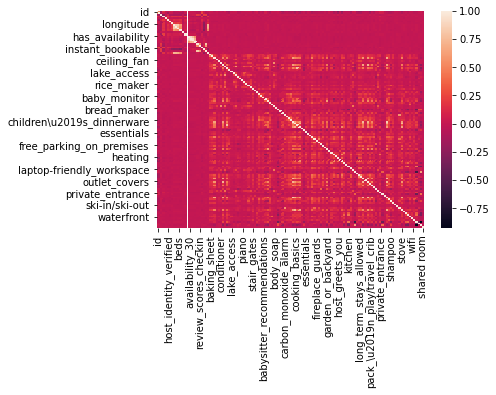

In [25]:
#sns.pairplot(airbnb_df, hue = 'price') #tiempo de computación demasiado largo

#Visualizamos los datos para ver su correlación 
diagonal_corr = airbnb_df.corr()
sns.heatmap(diagonal_corr) 


El mapa de correlación ploteado nos da la oportunidad de visualizar la correlación entre todas las variables de nuestra base de datos. No obstante, como se ha mencionado anteriormente y como podemos observar en la gráfica obtenida, dicha visualización no es interpretable teniendo en cuenta todas las variables de la base de datos. Por este motivo, se visualizarán las variables que, bajo propio criterio, interpretamos que deben tener más paso para el entrenamiento del modelo. Estas varaibles son:

* Precio, salida de nuestro modelo
* Tipo de alojamiento
* Número de habitaciones
* Número de camas
* Número de baños
* Las variables de latitud y longitud para la ubicación del alojamiento

Para ello se implementará una base de datos nueva para su visualización randozimada con un total de 200 muestras.

In [26]:
visualizacion_datos = airbnb_df.sample(frac=1, random_state=42)
visualizacion_datos = airbnb_df.loc[0:200,['entire home/apt', 'hotel room', 'private room', 'shared room',
                                'bedrooms', 'beds', 'num_bathrooms', 'latitude', 'longitude', 'price']]

#sns.pairplot(visualizacion_datos, hue='price') Tiempo de computación muy alto

<AxesSubplot:>

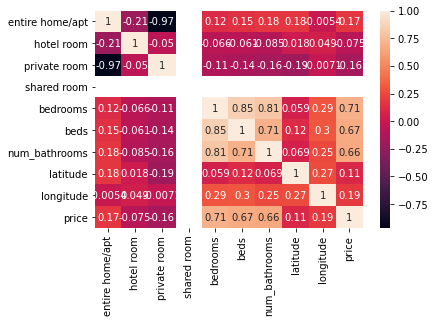

In [27]:
diagonal_corr_reducido = visualizacion_datos.corr()
sns.heatmap(diagonal_corr_reducido, annot = True)

Gracias al mapa de calor podemos visualizar la correlación entre las variables. Centrándose en la vairable de salida del modelo, 'price', observamos que la correlación entre las demás variables no es muy alta. Destaca por encima del resto el número de habitaciones, camas y baños. A simple vista, parece lo lógico. Sin embargo, algo a destacar es el tipo de habitación, en un inicia se esperaba que hubiese una mayor correlación. 

Para una mayor comprensión de los datos se decide visualizar las variables de mayor correlación.

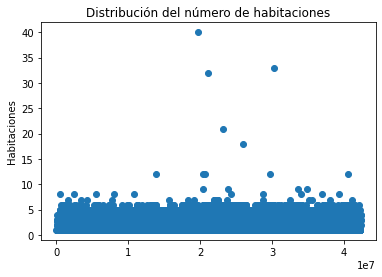

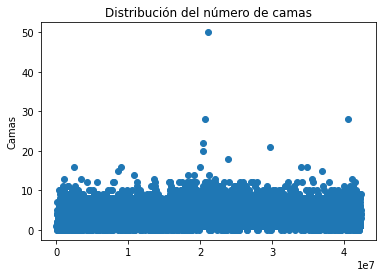

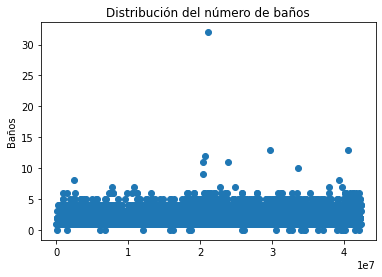

In [28]:
plot_col(airbnb_df, 'Distribución del número de habitaciones', airbnb_df['bedrooms'], 'Habitaciones')
plot_col(airbnb_df, 'Distribución del número de camas', airbnb_df['beds'], 'Camas')
plot_col(airbnb_df, 'Distribución del número de baños', airbnb_df['num_bathrooms'], 'Baños')

Con los plots de las variables más correlacionadas con el precio, podemos observar como sus muestras todas se hallan en valores parecidos a excipción de algunos outlieres. Teniendo en cuenta el filtrado realizado en la limpieza de la base de datos, no tendrían que ocasionarnos problemas a la hora de entrenar el modelo.

## 2. Implementación del modelo

### 2.1 Datos de entrenamiento y datos de testeo

Para la implementación del modelo es necesario dividir la base de datos en dos grupos. Una parte de la base de datos para realizar el entrenamineto del modelo y otra parte para el testeo del modelo. En otras palabras, usaremos el 80% de los datos para el entrenamiento del modelo y el 20% para testear como el modelo se comporta y predice correctamente. 


In [29]:
# Mezclamos el dataframe de forma aleatoria
airbnb_df = airbnb_df.sample(frac=1, random_state=42)

train_size = int(0.8*airbnb_df.shape[0])

df_train = airbnb_df.loc[:train_size]
df_test = airbnb_df.loc[train_size:]

#Separación entre las variables de entrada y la variable de salida (precio)
#Datos para el entrenamiento
x_train = df_train.drop('price', axis=1)
y_train = df_train['price']

#Datos para el testeo
x_test = df_train.drop('price', axis=1)
y_test = df_train['price']

### 2.2 Normalización de los datos

La base de datos está formada por variables con destintas medidas, por este motivo se decide estanderizar/normalizar los datos. Para ello se ha implementado una función para normalizar los datos, en dicha función se usa la función 'StandScaler' de Scikitlern.


#### Función para normalizar datos 

In [30]:
def normalize_function(X):
    scaler= StandardScaler().fit(X) #Escalamos los datos 
    X_n = scaler.transform(X)
    return X_n

#### Normalización de los datos

In [31]:
x_train_n = normalize_function(x_train) 
x_test_n = normalize_function(x_test) 

Una vez separados los datos en datos de entrenamiento y datos de testeo y su respectiva estanderización, ya tenemos listos los datos para la implementación del modelo.

### 2.4 Método de regresión

### k-Nearest Neighboor

Se ha decidido implementar un modelo que sea capaz de clasificar los precios de los alojamientos. Para el entrenamiento del modelo se aplicarán algoritmos de regresión. Se decide en un primer momento seguir el método k-Nearest Neighbor. Es un algoritmo basado en instancia de tipo supervisado de Machine Learning. Así pues, es un método que simplemente busca en las observaciones más cercanas a la que se está tratando de predecir y clasifica el punto de interés basado en la mayoría de datos que le rodean. 

El mayor problema para de usar este método es obtener el número óptimo de vecinos. Para ello se usará el método de evaluación cruzada que trabaja con las particiones distintas de la base de datos para estimar la precisión del modelo. Vamos a calcular una estimación del R2 usando varios rangos (0-25, 25-50, 50-80). 



#### Funciones para el número óptimo de vecinos

Al usar 3 rangos se decide implementar una funcion para obtener el valor de R2 para cada posible número de vecinos  y se implementa un función que devuelva el valor máximo de R2 en cada rango y, por ende, poder obtener el número óptimo de vecinos para el modelo.

In [32]:
def n_neighbors(rango):
    
    k_range =rango
    k_result = []
    
    for k in k_range:
        knn = KNeighborsRegressor(n_neighbors = k, algorithm = 'auto')
        result = cross_val_score(knn, x_train_n, y_train, cv = 10, scoring = 'r2')
        k_result.append(result.mean())
            
    return k_result  

def max_neighbors(k_result):
    max_value = None
    max_idx = None

    for idx, num in enumerate(k_result):
        if (max_value is None or num > max_value):
            max_value = num
            max_idx = idx

    print('Valor máximo de R2:', max_value, "Numero de vecinos: ", max_idx)

In [33]:
#Calculamos R2 para cada número de vecinos
#Rango 0-25
n_neighbors_0_25 = n_neighbors(range(1,25))
#Rango 25-50
n_neighbors_25_50 = n_neighbors(range(25,50))
#Rango 50-80
n_neighbors_50_80 = n_neighbors(range(50,80))

In [34]:
#Obtenemos el número óptimo
max_neighbors(n_neighbors_0_25)
max_neighbors(n_neighbors_25_50)
max_neighbors(n_neighbors_50_80)

Valor máximo de R2: 0.2639820539057788 Numero de vecinos:  23
Valor máximo de R2: 0.27449198890881354 Numero de vecinos:  15
Valor máximo de R2: 0.2738801802304907 Numero de vecinos:  0


Una vez realizada esta simulación, observamos como el número óptimo se encuentra en el rango 25-50 y corresponde a la iteración 15, es decir, el número óptimo de vecinos es 40 (25+15). Así pues, ya podemos realizar el entrenaiento del modelo.

#### Entrenamineto del modelo

In [35]:
knn = KNeighborsRegressor(n_neighbors = 40, algorithm = 'auto')
knn.fit(x_train_n, y_train)
knn._fit_method

'kd_tree'

El parámetro 'algorithm' se le atribuye el valor 'auto' ya que con dicho valor el modelo elige el algoritmo que mejor se ajuste a los datos. El mejor algoritmo a aplicar para nuestra base de datos es el 'kd_tree'.             

Es momento de predecir los valores de los precios y comprobar así si el modelo trabaja correctamente.

In [36]:
y_predict = knn.predict(x_test_n)
y_predict

array([158.9  , 169.2  , 169.758, ..., 120.15 , 182.725, 194.625])

Una vez predecido los valores de salida, es momento de comprobar si el modelo trabaja correctamente o no. Para ello se hace uso de las métricas. En este caso, se opta por usar el RMSE y R2.


In [37]:
rmse = (mean_squared_error(y_test, y_predict))**(1/2) #RSME
r2 = r2_score(y_test, y_predict)
print('RMSE: ', rmse, ' R2: ', r2)

RMSE:  70.55349687263796  R2:  0.3137473416675257


Se ha obtenido un RMSE de 70.55 y un R2 de 0.31. Así pues, a través de estas métricas podemos concretar que el modelo predice los precios de los alojamientos con un error medio de 70 dólares, este error quizás podría ser aceptable para alojamientos con un precio superior a los 400 dólares. Sin embargo, con el valor de R2 observamos que el modelo se ajusta a los datos un 31.37%, presenta underfitting. 

Visto los resultados de las métricas obtenidos, vamos a implementar un modelo de regresión lineal a ver si obtenemos unas mejores métricas y, por ende, un mejor modelo.

### Regresión lineal

La regresión lineal es un método estadístico que trata de modelar la relación entre una variable continua y una o más variables independientes mediante el ajuste de una ecuación lineal. En nuestro caso, tan solo contamos con una variable independiente (de salida), el precio del alojamiento, y, por ende, se trata de regresión lineal simple. Si nuestra base de datos tuviera más variables independientes se trataría de un regresión lineal múltiple.

Teniendo en cuenta que las bases del modelo se han implementado al inicio del entrenamiento, seprarando los datos de entrenamiento y testeo, y su posterior normalización. Para el modelo de regresión lineal tan sólo es necesario entrenar el modelo con dicho método.

#### Entrenamiento del modelo

In [38]:
reg_lr = LinearRegression()
reg_lr.fit(x_train_n, y_train)

LinearRegression()

Predecimos los valores de salida del modelo, es decir, los precios de los alojamientos de los datos de testeo.

In [39]:
y_predict_reg_lr = reg_lr.predict(x_test_n)
y_predict_reg_lr

array([ 91.79234521, 147.87828271, 132.26500146, ...,  92.81187646,
       234.78062646, 186.02672021])

Como ha ocurrido con el modelo de k-Nearest Neighboor, es momento de hacer uso de las métricas para comprobar el comportamiento del modelo.

In [40]:
rmse_reg_lr = (mean_squared_error(y_test, y_predict_reg_lr))**(1/2) #RSME
r2_reg_lr = r2_score(y_test, y_predict_reg_lr)
print('RMSE: ', rmse_reg_lr, ' R2: ', r2_reg_lr)

RMSE:  62.443217415223145  R2:  0.4624516951297243


A través de la regresión lineal se han obtenido resultados mejores. El modelo presenta un error medio de 62.44 dólares a la hora de predecir el precio del alojamiento y se ajusta un 46.24% a los datos. En otras palabras, el modelo entrenado con una regresión lineal predice los precios de los alojamientos con un menor error que con un modelo entrenado con el método de       k-Nearest Neighboor y se ajusta más a los datos. 